In [1085]:
import numpy as np
import pandas as pd
from datetime import datetime

import plotly.graph_objects as go
from ta.trend import MACD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from matplotlib import pyplot as plt

pd.get_option("display.max_columns")

20

In [1086]:
def load_configs(config: str = "btc"):
    is_time_aggregate = False
    if config == "btc":
        filename = "test.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    elif config == "eth":        
        filename = "test_ethusd.csv"
        trades_per_candle = 1000
        do_aggregate = True
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    else:
        filename = "test_ethusdt_time_series.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy", "Trades"])
        is_time_aggregate = True
    threshold = 0.0
    return filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate

filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate = load_configs("else")

In [1087]:
df["Timestamp"] = df["Timestamp"].apply(lambda row: pd.to_datetime(row,unit='ms'))

def draw(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Timestamp'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
draw(df)

In [1088]:
df.head(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
0,2900.48,2903.03,2899.28,2902.23,5.644723e+05,2021-09-28 10:30:34.524,140,361
1,2902.08,2902.23,2894.81,2896.95,8.312620e+05,2021-09-28 10:31:34.911,250,431
2,2896.99,2902.34,2896.99,2901.09,5.649050e+05,2021-09-28 10:32:35.495,162,284
3,2901.34,2904.62,2900.80,2904.62,3.378702e+05,2021-09-28 10:33:35.565,99,251
4,2904.63,2906.77,2903.32,2905.66,8.657689e+05,2021-09-28 10:34:35.747,230,469
5,2905.66,2905.66,2898.45,2901.02,2.868255e+05,2021-09-28 10:35:36.178,168,277
6,2901.01,2905.01,2900.00,2904.94,3.505611e+05,2021-09-28 10:36:36.953,136,267
7,2904.94,2906.06,2902.22,2903.05,3.088425e+05,2021-09-28 10:37:36.960,155,276
8,2903.14,2903.14,2898.29,2899.71,9.597596e+05,2021-09-28 10:38:38.481,211,487
9,2899.60,2899.92,2893.44,2897.53,1.067996e+06,2021-09-28 10:39:38.776,340,610


In [1089]:
def aggregate(each: int = 10):
    new_df = pd.DataFrame()
    new_df["Open"] = df["Open"].groupby(df.index // each).first()
    new_df["High"] = df["High"].groupby(df.index // each).max()
    new_df["Low"] = df["Low"].groupby(df.index // each).min()
    new_df["Close"] = df["Close"].groupby(df.index // each).last()
    new_df["Volume"] = df["Volume"].groupby(df.index // each).sum()
    new_df["Timestamp"] = df["Timestamp"].groupby(df.index // each).min()
    new_df["SelltoBuy"] = df["SelltoBuy"].groupby(df.index // each).sum()
    return new_df

if do_aggregate:
    new_df = aggregate()

In [1090]:
if do_aggregate:
    df = new_df
    draw(df)

In [1091]:
df.tail(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
998,2860.66,2861.41,2859.33,2860.51,5.914299e+05,2021-09-29 03:21:18.106,111,367
999,2860.53,2862.52,2857.24,2857.74,5.478175e+05,2021-09-29 03:22:19.053,204,516
1000,2857.74,2859.10,2853.69,2854.10,5.865711e+05,2021-09-29 03:23:19.086,177,391
1001,2854.10,2860.00,2853.75,2859.68,2.378238e+05,2021-09-29 03:24:19.233,87,314
1002,2859.95,2863.27,2859.58,2863.00,5.116376e+05,2021-09-29 03:25:19.596,98,364
1003,2863.01,2863.96,2860.84,2861.64,4.304299e+05,2021-09-29 03:26:19.721,154,372
1004,2861.64,2861.65,2857.51,2861.13,1.462850e+06,2021-09-29 03:27:21.132,390,645
1005,2861.00,2863.00,2858.55,2862.62,3.306742e+05,2021-09-29 03:28:21.427,148,397
1006,2862.91,2866.63,2862.55,2864.76,5.372405e+05,2021-09-29 03:29:21.679,104,357
1007,2864.76,2864.76,2861.92,2862.22,2.682420e+05,2021-09-29 03:30:21.823,134,335


In [1092]:
# df.to_csv('ethbtc.csv', index=False)

In [1093]:
def create_signal(signal_col_name:str = "simple_signal", buy_side_col:str = "pct_change", sell_side_col:str = "pct_change"):
    conditions = [(df[buy_side_col] > threshold), (df[sell_side_col] < -threshold)]
    choices = [1, -1]
    df[signal_col_name] = np.select(conditions, choices, default=0)


def signal_analytics(signal_col_name: str = "simple_signal"):
    signals_total = df[signal_col_name][df[signal_col_name] != 0].count()
    df_len = len(df)
    print(f"Buy signals total: {df[signal_col_name][df[signal_col_name] > 0].sum()}")
    print(f"Sell signals total: {abs(df[signal_col_name][df[signal_col_name] < 0].sum())}")
    print(f"Signals total: {signals_total}")
    print(f"Candles observed: {df_len}")
    print(f"Signal to candle ratio: {round(signals_total/df_len, 4)*100}%")


In [1094]:
df['pct_change'] = df["Close"].pct_change() * 100

create_signal()
signal_analytics()
df.tail(50)

Buy signals total: 523
Sell signals total: 519
Signals total: 1042
Candles observed: 1048
Signal to candle ratio: 99.42999999999999%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal
998,2860.66,2861.41,2859.33,2860.51,5.914299e+05,2021-09-29 03:21:18.106,111,367,-0.005244,-1
999,2860.53,2862.52,2857.24,2857.74,5.478175e+05,2021-09-29 03:22:19.053,204,516,-0.096836,-1
1000,2857.74,2859.10,2853.69,2854.10,5.865711e+05,2021-09-29 03:23:19.086,177,391,-0.127373,-1
1001,2854.10,2860.00,2853.75,2859.68,2.378238e+05,2021-09-29 03:24:19.233,87,314,0.195508,1
1002,2859.95,2863.27,2859.58,2863.00,5.116376e+05,2021-09-29 03:25:19.596,98,364,0.116097,1
1003,2863.01,2863.96,2860.84,2861.64,4.304299e+05,2021-09-29 03:26:19.721,154,372,-0.047503,-1
1004,2861.64,2861.65,2857.51,2861.13,1.462850e+06,2021-09-29 03:27:21.132,390,645,-0.017822,-1
1005,2861.00,2863.00,2858.55,2862.62,3.306742e+05,2021-09-29 03:28:21.427,148,397,0.052077,1
1006,2862.91,2866.63,2862.55,2864.76,5.372405e+05,2021-09-29 03:29:21.679,104,357,0.074757,1
1007,2864.76,2864.76,2861.92,2862.22,2.682420e+05,2021-09-29 03:30:21.823,134,335,-0.088664,-1


In [1095]:
df['open_high_pct_change'] = (df['High'] - df['Open']) / df['Open'] * 100
df['open_low_pct_change'] = (df["Low"] - df["Open"]) / df["Open"] * 100

signal_take_profit = "signal_take_profit"

create_signal(signal_take_profit, "open_high_pct_change", "open_low_pct_change")
signal_analytics(signal_col_name = signal_take_profit)

df.tail(50)

Buy signals total: 980
Sell signals total: 68
Signals total: 1048
Candles observed: 1048
Signal to candle ratio: 100.0%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit
998,2860.66,2861.41,2859.33,2860.51,5.914299e+05,2021-09-29 03:21:18.106,111,367,-0.005244,-1,0.026218,-0.046493,1
999,2860.53,2862.52,2857.24,2857.74,5.478175e+05,2021-09-29 03:22:19.053,204,516,-0.096836,-1,0.069568,-0.115014,1
1000,2857.74,2859.10,2853.69,2854.10,5.865711e+05,2021-09-29 03:23:19.086,177,391,-0.127373,-1,0.047590,-0.141720,1
1001,2854.10,2860.00,2853.75,2859.68,2.378238e+05,2021-09-29 03:24:19.233,87,314,0.195508,1,0.206720,-0.012263,1
1002,2859.95,2863.27,2859.58,2863.00,5.116376e+05,2021-09-29 03:25:19.596,98,364,0.116097,1,0.116086,-0.012937,1
1003,2863.01,2863.96,2860.84,2861.64,4.304299e+05,2021-09-29 03:26:19.721,154,372,-0.047503,-1,0.033182,-0.075794,1
1004,2861.64,2861.65,2857.51,2861.13,1.462850e+06,2021-09-29 03:27:21.132,390,645,-0.017822,-1,0.000349,-0.144323,1
1005,2861.00,2863.00,2858.55,2862.62,3.306742e+05,2021-09-29 03:28:21.427,148,397,0.052077,1,0.069906,-0.085634,1
1006,2862.91,2866.63,2862.55,2864.76,5.372405e+05,2021-09-29 03:29:21.679,104,357,0.074757,1,0.129938,-0.012575,1
1007,2864.76,2864.76,2861.92,2862.22,2.682420e+05,2021-09-29 03:30:21.823,134,335,-0.088664,-1,0.000000,-0.099136,-1


In [1096]:
df["sell_to_buy_ratio"] = (df["SelltoBuy"] / trades_per_candle) if not is_time_aggregate else df["SelltoBuy"] / df["Trades"] 
df = df.drop(columns=["SelltoBuy"])

In [1097]:
# df["secs_between_candles"] = df["Timestamp"] - df["Timestamp"].shift(1)
# df["secs_between_candles"] = df['secs_between_candles'].dt.total_seconds()
df = df.drop(columns=["Timestamp"])

In [1098]:
df["ss_next"] = df["simple_signal"].shift(-1)
df["stp_next"] = df["signal_take_profit"].shift(-1)

In [1099]:
# df["vol_pct_change"] = (df["Volume"] - df["Volume"].shift(1))/df["Volume"].shift(1)
# df["vol_per_sec"] = np.log(df["Volume"] / df["secs_between_candles"]) # Can remove log if needed
# df = df.drop(columns=["Volume"])

In [1100]:
indicator_macd = MACD(close = df['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['momentum'] = df['pct_change'].rolling(5).mean().shift(1)
df['distance'] = (df["Close"] - df["Close"].rolling(50).mean()).shift(1)

In [1101]:
df = df.drop(columns=["Open", "Close", "High", "Low"])

In [1102]:
print(df.shape)
df.head(50)

(1048, 14)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,macd,macd_diff,momentum,distance
0,5.644723e+05,361,NaN,0,0.087916,-0.041372,1,0.387812,-1.0,1.0,NaN,NaN,NaN,NaN
1,8.312620e+05,431,-0.181929,-1,0.005169,-0.250510,1,0.580046,1.0,1.0,NaN,NaN,NaN,NaN
2,5.649050e+05,284,0.142909,1,0.184674,0.000000,1,0.570423,1.0,1.0,NaN,NaN,NaN,NaN
3,3.378702e+05,251,0.121678,1,0.113051,-0.018612,1,0.394422,1.0,1.0,NaN,NaN,NaN,NaN
4,8.657689e+05,469,0.035805,1,0.073675,-0.045100,1,0.490405,-1.0,-1.0,NaN,NaN,NaN,NaN
5,2.868255e+05,277,-0.159688,-1,0.000000,-0.248136,-1,0.606498,1.0,1.0,NaN,NaN,NaN,NaN
6,3.505611e+05,267,0.135125,1,0.137883,-0.034815,1,0.509363,-1.0,1.0,NaN,NaN,-0.008245,NaN
7,3.088425e+05,276,-0.065062,-1,0.038555,-0.093634,1,0.561594,-1.0,-1.0,NaN,NaN,0.055166,NaN
8,9.597596e+05,487,-0.115051,-1,0.000000,-0.167060,-1,0.433265,-1.0,1.0,NaN,NaN,0.013572,NaN
9,1.067996e+06,610,-0.075180,-1,0.011036,-0.212443,1,0.557377,1.0,1.0,NaN,NaN,-0.033774,NaN


In [1103]:
def introduce_shift(depth: int = 1):
    for i in range(depth):
        df[f"pct_change_{i+1}"] = df["pct_change"].shift(i+1)
        df[f"open_high_pct_change_{i+1}"] = df["open_high_pct_change"].shift(i+1)
        df[f"open_low_pct_change_{i+1}"] = df["open_low_pct_change"].shift(i+1)
        df[f"sell_to_buy_ratio_{i+1}"] = df["sell_to_buy_ratio"].shift(i+1)
#         df[f"secs_between_candles_{i+1}"] = df["secs_between_candles"].shift(i+1)

In [1104]:
introduce_shift(1)
df.dropna(inplace=True)

In [1105]:
print(df.shape)
df.tail(50)

(997, 18)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,macd,macd_diff,momentum,distance,pct_change_1,open_high_pct_change_1,open_low_pct_change_1,sell_to_buy_ratio_1
997,3.328674e+05,316,0.067162,1,0.067860,0.000000,1,0.240506,-1.0,1.0,-2.690085,-0.149161,-0.023857,-9.2236,0.118724,0.130281,-0.020663,0.278788
998,5.914299e+05,367,-0.005244,-1,0.026218,-0.046493,1,0.302452,-1.0,1.0,-2.460880,0.064036,-0.008328,-6.9260,0.067162,0.067860,0.000000,0.240506
999,5.478175e+05,516,-0.096836,-1,0.069568,-0.115014,1,0.395349,-1.0,1.0,-2.474227,0.040551,0.004041,-6.7674,-0.005244,0.026218,-0.046493,0.302452
1000,5.865711e+05,391,-0.127373,-1,0.047590,-0.141720,1,0.452685,1.0,1.0,-2.746858,-0.185664,0.022367,-9.2700,-0.096836,0.069568,-0.115014,0.395349
1001,2.378238e+05,314,0.195508,1,0.206720,-0.012263,1,0.277070,1.0,1.0,-2.484027,0.061734,-0.008713,-12.5430,-0.127373,0.047590,-0.141720,0.452685
1002,5.116376e+05,364,0.116097,1,0.116086,-0.012937,1,0.269231,-1.0,1.0,-1.984954,0.448645,0.006644,-6.7194,0.195508,0.206720,-0.012263,0.277070
1003,4.304299e+05,372,-0.047503,-1,0.033182,-0.075794,1,0.413978,-1.0,1.0,-1.679811,0.603030,0.016430,-3.2114,0.116097,0.116086,-0.012937,0.269231
1004,1.462850e+06,645,-0.017822,-1,0.000349,-0.144323,1,0.604651,1.0,1.0,-1.462280,0.656449,0.007979,-4.3464,-0.047503,0.033182,-0.075794,0.413978
1005,3.306742e+05,397,0.052077,1,0.069906,-0.085634,1,0.372796,1.0,1.0,-1.156326,0.769923,0.023781,-4.6874,-0.017822,0.000349,-0.144323,0.604651
1006,5.372405e+05,357,0.074757,1,0.129938,-0.012575,1,0.291317,-1.0,-1.0,-0.732728,0.954817,0.059672,-3.0910,0.052077,0.069906,-0.085634,0.372796


In [1106]:
# y_s = df["simple_signal"]
# y_tp = df["signal_take_profit"]
# df = df.drop(columns=["ss_next", "stp_next"])
# X = df.drop(columns=["simple_signal", "signal_take_profit"])

In [1107]:
y_s = df["ss_next"]
y_tp = df["stp_next"]
X = df.drop(columns=["ss_next", "stp_next"])
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.15, random_state=42, shuffle=False)
X_train_tp, X_test_tp, y_train_tp, y_test_tp = train_test_split(X, y_tp, test_size=0.15, random_state=42, shuffle=False)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)
print(X_train_tp.shape, X_test_tp.shape, y_train_tp.shape, y_test_tp.shape)

(847, 16) (150, 16) (847,) (150,)
(847, 16) (150, 16) (847,) (150,)


In [1108]:
# print(X_train_s[-10:])
# print(X_test_s[:10])

In [1109]:
def model_train(X_train, y_train):
    model = RandomForestClassifier(n_estimators=3000, max_depth=4)
#     model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0)
#     model = LogisticRegression(multi_class='ovr', penalty="elasticnet", l1_ratio=0.5, C=0.01, solver="saga")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=10)
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=0.1)
#     model = SVC(C=0.1, gamma="auto", class_weight="balanced")
        
#     make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     model = LogisticRegression(multi_class='ovr', C=0.01)
#     model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    return model

model_s = model_train(X_train_s, y_train_s)
model_tp = model_train(X_train_tp, y_train_tp)

def model_predict_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
model_predict_evaluate(model_s, X_train_s, y_train_s)
# model_predict_evaluate(model_tp, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

        -1.0       0.78      0.80      0.79       440
         0.0       0.00      0.00      0.00         3
         1.0       0.77      0.76      0.77       404

    accuracy                           0.78       847
   macro avg       0.52      0.52      0.52       847
weighted avg       0.77      0.78      0.77       847



/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [1110]:
model_predict_evaluate(model_s, X_test_s, y_test_s)
# model_predict_evaluate(model_tp, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

        -1.0       0.41      0.78      0.53        58
         0.0       0.00      0.00      0.00         1
         1.0       0.64      0.27      0.38        91

    accuracy                           0.47       150
   macro avg       0.35      0.35      0.31       150
weighted avg       0.55      0.47      0.44       150



/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<BarContainer object of 16 artists>

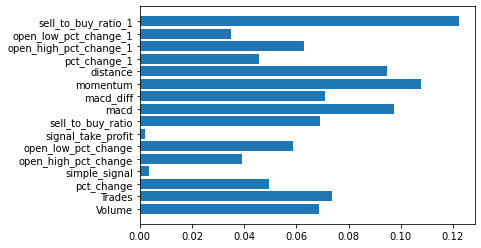

In [1111]:
plt.barh(list(X), model_tp.feature_importances_)

In [1112]:
# TODO:
# 1. Think on a model that would make for a good demo. There are several options:
#  a. Have labels that are related to some window in which the price changes significantly enough.
# We can reuse existing aggregations for such model.
#  b. Have a higher resolution of the aggregations (10k events instead of 1000 events for BTC). Can post-process existing data
# in fine resolution to arrive at new aggregations using a Python script.
#  c. Select a high-volume and high-volatility pair (e.g. ETHUSDT) that would yield signals more often.

In [1113]:
# df.dropna(inplace=True)

In [1114]:
# df.to_csv('ethbtc.csv', index=False)